In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import math
import numpy as np 
import seaborn as sns

class TSP():
    cities = 0
    distances = []
    locations = []
    
    def distance(self, c1, c2):
        loc1, loc2 = self.locations[c1], self.locations[c2]
        return math.sqrt((loc1[0]-loc2[0])**2 + (loc1[1]-loc2[1])**2)
    
    def __init__(self, cities, seed=1):
        random.seed(seed)
        self.cities = cities
        
        self.locations = []
        for i in range(cities):
            self.locations.append((random.random(), random.random()))
        
        self.distances = []
        for i in range(cities):
            self.distances.append([])
            for j in range(cities):
                self.distances[i].append(self.distance(i, j))
                
    def random_solution(self):
        s = [i for i in range(self.cities)]
        random.shuffle(s)
        return s
    
    def evaluate(self, s):
        fit = 0
        for i in range(len(s)):
            fit += self.distances[s[i]][s[i+1 if i+1<len(s) else 0]]
        return fit
    
    def mutate(self, s):
        sol = s[:]
        c1, c2 = random.sample(range(0, self.cities), 2)
        if c2 < c1:
            ctmp = c1
            c1 = c2
            c2 = ctmp
        rev = sol[c1:c2+1]
        rev.reverse()
        sol[c1:c2+1] = rev
        return sol
    
    def crossover(self, s1, s2):
        sol1, sol2 = s1[:], s2[:]
        c1, c2 = random.sample(range(0, self.cities), 2)
        if c2 < c1:
            ctmp = c1
            c1 = c2
            c2 = ctmp
        sol1[c1:c2+1] = list(filter(lambda x: x in sol1[c1:c2+1], s2))
        sol2[c1:c2+1] = list(filter(lambda x: x in sol2[c1:c2+1], s1))
        
        return sol1, sol2
    
    def display_solution_param(self, solution):
        fig, ax = plt.subplots(figsize=(8, 8))

        x = [i[1] for i in [self.locations[c] for c in solution]]
        y = [i[0] for i in [self.locations[c] for c in solution]]
        x.append(x[0])
        y.append(y[0])
        line, = ax.plot(x, y, 'go-',linewidth=2)
            
        plt.xlim((-0.03,1.03))
        plt.ylim((-0.03,1.03))
        plt.show()

**Task 1:** Implement the generational evolutionary algorithm with tournament selection. Let it be parametrized with four parameters: the size of the population $N$, the size of the tournament $t$, the probability of mutation $p_m$ and the probability of crossover $p_c$. The algorithm should terminate automatically after 50 generations with no improvement.

In [53]:
def tournament(population, population_eval, tourment_size):
    random_solutions = np.random.permutation(len(population))[:tourment_size]
    random_solutions.sort()
    best_solution_arg = np.argmin(population_eval[random_solutions])
#     print(random_solutions, best_solution_arg, np.max(population_eval[random_solutions]), np.min(population_eval[random_solutions]), population_eval[random_solutions])
    return random_solutions[best_solution_arg] # index of best solution 


def evolutionary_algorithm(problem, N, t, p_m, p_c, const_no_evaluation=False):
    population = []
    population_eval = []
    
    for n in range(N):
        sol = problem.random_solution()
        population.append(sol)
        population_eval.append(problem.evaluate(sol))

    population_eval = np.array(population_eval)
    # print(population_eval)
    avg_eval = [np.average(population_eval)]
    gens_without_improvement = 0
    
    while (gens_without_improvement < 50 and not const_no_evaluation) or (const_no_evaluation and len(avg_eval) < 50):
        new_population = []
        new_population_eval = []
        while len(new_population_eval) < N:
            if random.random() < p_c:
                new_solution_1 = population[tournament(population, population_eval, t)]
                new_solution_2 = population[tournament(population, population_eval, t)]
                new_solution_1, new_solution_2 = problem.crossover(new_solution_1, new_solution_2)
                if random.random() < p_m:
                    new_solution_1 = problem.mutate(new_solution_1)
                new_population.append(new_solution_1)
                new_population_eval.append(problem.evaluate(new_solution_1))

                if len(new_population_eval) >= N:
                    break

                if random.random() < p_m:
                    new_solution_2 = problem.mutate(new_solution_2)
                new_population.append(new_solution_2)
                new_population_eval.append(problem.evaluate(new_solution_2))

            else: 
                new_solution = population[tournament(population, population_eval, t)]
                if random.random() < p_m:
                    new_solution = problem.mutate(new_solution)
                new_population.append(new_solution)
                new_population_eval.append(problem.evaluate(new_solution))
                
        population = new_population
        population_eval = np.array(new_population_eval)
        avg_eval.append(np.average(population_eval))
        if len(avg_eval) > 2 and avg_eval[-2] <= avg_eval[-1]:
            gens_without_improvement += 1
        
    return population, population_eval, avg_eval

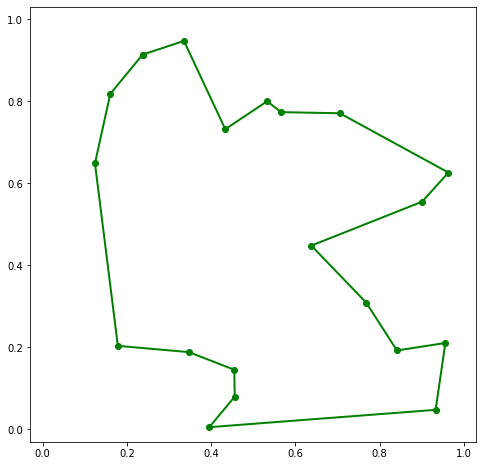

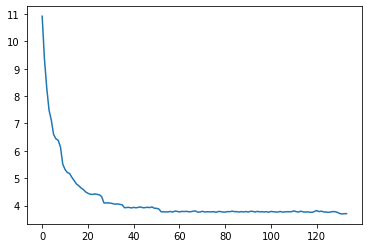

In [51]:
N = 300 # population size
t = 10 # size of tournament
p_m = 0.05 # prob of mutation
p_c = 0.05 # prob of crossover

tsp = TSP(20, seed=100) 


population, population_eval, avg_eval = evolutionary_algorithm(tsp, N, t, p_m, p_c)
arg = np.argmin(population_eval)
tsp.display_solution_param(population[arg])
plt.plot(avg_eval)

**Task 2:**

* What is the role of a mutation operator in evolutionary algorithms?
* What are the properties of a good mutation operator?
* What is the role of a crossover operator in evolutionary algorithms?
* What are the properties of a good crossover operator?
* What is the role of a cloning operator in evolutionary algorithms?
* What are the properties of a good genetic representation?
* How can you tell that the population has converged?
* How do the parameters of the evolutionary algorithm affect the speed of its convergence?
* Does the speed of the algorithm's convergence correlate with the quality of the solutions? What is the reason?
* Can a population escape from a local optimum once it has converged?


* What are the strengths of the evolutionary algorithms?
* What are the weaknesses of the evolutionary algorithms?
* What changes would you introduce to the evolutionary algorithms?
* Which problems are evolutionary algorithms best suited for?

**Task 3:** Implement the QAP (https://en.wikipedia.org/wiki/Quadratic_assignment_problem). Use EA to solve it.

In [21]:
class QAP():
    # https://arxiv.org/ftp/arxiv/papers/1405/1405.5050.pdf
    # https://www.localsolver.com/docs/last/exampletour/qap.html
    # sol[i] is the facility on the location i
    n = 0 
    distances = np.zeros((1,1))
    flows = np.zeros((1,1))
    
    def __init__(self, n, seed=1):
        # n should be grater than 2
        random.seed(seed)
        np.random.seed(seed)
        self.n = n 
        
        b = np.random.randint(0, 100, (self.n,self.n)) * 2
        np.fill_diagonal(b, 0)
        self.distances = (b + b.T)/2

        b = np.random.randint(0, 20, (self.n,self.n)) * 2
        np.fill_diagonal(b, 0)
        self.flows = (b + b.T)/2
        
    def random_solution(self):
        s = [i for i in range(self.n)]
        random.shuffle(s)        
        return s
    
    def evaluate(self, s):
        fit = np.sum([self.distances[i, j] * self.flows[s[i], s[j]] 
                      for i in range(self.n) for j in range(self.n)])     
        return fit
    
    def mutate(self, s):
        # change position of two facilities 
        sol = s[:]
        pos = random.sample(range(0, self.n), 2)
        temp = sol[pos[0]]
        sol[pos[0]] = sol[pos[1]]
        sol[pos[1]] = temp
        return sol
    
    def _increment_i(self, i, fixed_pos):
        if i + 1 in fixed_pos and i + 2 in fixed_pos:
            return i + 3
        elif i + 1 in fixed_pos:
            return i + 2
        else:
            return i + 1
    
    def _create_child(self, parent1, parent2, fixed_pos):
        # parent1 - fixed positions are the same, the rest is from parent 2
        child = [-1 for i in range(self.n)]
        fixed_val = [parent1[fixed_pos[0]], parent1[fixed_pos[1]]]
        child[fixed_pos[0]], child[fixed_pos[1]] = parent1[fixed_pos[0]], parent1[fixed_pos[1]]
        
        p1_i = self._increment_i(-1, fixed_pos)
            
        for p2_i in range(self.n):
            val = parent2[p2_i] 
            if val not in fixed_val:
                child[p1_i] = val
                p1_i = self._increment_i(p1_i, fixed_pos)

        return child
        
    
    def crossover(self, s1, s2):
        sol1, sol2 = s1[:], s2[:]
        fixed_pos = random.sample(range(0, self.n), 2)
        sol1 = self._create_child(s1, s2, fixed_pos)
        sol2 = self._create_child(s2, s1, fixed_pos)
        return sol1, sol2

[398975.38, 390209.16, 384104.49333333335, 379952.7, 379476.50666666665, 379160.86666666664, 378940.2733333333, 378281.43333333335, 377284.2733333333, 377041.61333333334, 375161.36666666664, 374836.9733333333, 373469.25333333336, 372853.5933333333, 372876.5, 372931.22, 373043.20666666667, 373253.3466666667, 372249.5333333333, 371517.1533333333, 371251.96, 371288.98, 371166.9666666667, 370758.4, 370627.0933333333, 370636.9666666667, 369272.11333333334, 369015.2266666667, 367690.06666666665, 367200.2266666667, 365231.50666666665, 364853.34, 364938.50666666665, 364795.81333333335, 364776.36, 365153.0133333333, 363807.0266666667, 361124.64666666667, 361091.36666666664, 361004.14, 361020.35333333333, 360985.81333333335, 360936.94, 360244.1066666667, 360507.29333333333, 359918.44666666666, 360244.6, 359854.3, 360347.82, 359969.8333333333, 360185.75333333336, 359909.26, 360076.7866666667, 360435.74, 360165.23333333334, 359953.13333333336, 360099.06, 360239.7733333333, 359754.05333333334, 3601

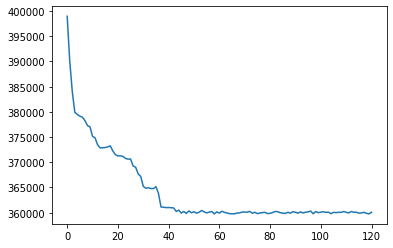

In [22]:
qap = QAP(15)
population, population_eval, avg_eval = evolutionary_algorithm(qap, N, t, p_m, p_c)
print(avg_eval)
plt.plot(avg_eval)

**Task 4:** Choose one of the problems (TSP or QAP). Assume a constant number of fitness evaluations per each evolutionary run. For a sufficiently big (nontrivial) problem:

a) Assume $N = 200$, $t = 5$. Prepare a heatmap illustrating the influence of values of $p_m$ and $p_c$ on the quality of the solution.

b) Assume $p_m = 0.5$, $p_c = 0.5$. Prepare a heatmap illustrating the influence of values of $N$ and $t$ on the quality of the solution.

Discuss the results. Can we expect to see similar results under different search termination conditions (e.g. a number of iterations with no improvement)? Can we expect to see similar results for different optimization problems?

In [65]:
N = 200
t = 5
size = 10

evals = np.zeros(shape=(size, size ))
for i in range(size):
    for j in range(size):
        p_m_ = i / (size - 1)
        p_c_ = j / (size - 1)
        tsp = TSP(20, seed=100) 
        population, population_eval, avg_eval = evolutionary_algorithm(tsp, N, t, p_m_, p_c_, True)
        evals[i, j] = avg_eval[-1]

        
evals = evals / np.max(evals)

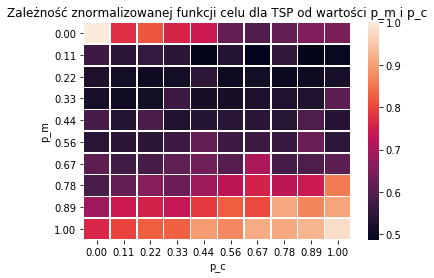

In [66]:
tick_label = [f"{i / (size - 1):.2f}" for i in range(size)]
ax = sns.heatmap(evals, linewidth=0.5, xticklabels=tick_label, yticklabels=tick_label)
plt.xlabel("p_c")
plt.ylabel("p_m")
# plt.show()
plt.title("Zależność znormalizowanej funkcji celu dla TSP od wartości p_m i p_c")

plt.savefig("heat_map_1.png")

In [69]:
p_m, p_c = 0.5, 0.5 
N_size = 25
t_size = 5
evals = np.zeros(shape=(N_size, t_size ))
for i in range(N_size):
    for j in range(t_size):
        tsp = TSP(20, seed=100) 
        population, population_eval, avg_eval = evolutionary_algorithm(tsp, i * 15 + 15, j + 1, p_m, p_c)
        evals[i, j] = avg_eval[-1]
        
        
evals = evals / np.max(evals)

[[0.9300286  0.57458521 0.49419229 0.37745165 0.41097298]
 [1.         0.67811804 0.37508636 0.41577348 0.41587899]
 [0.97312626 0.56225392 0.384356   0.36214873 0.35196794]
 [0.95969055 0.6096311  0.36174109 0.37078001 0.39410036]
 [0.99144088 0.56678126 0.39209653 0.36692035 0.40144185]
 [0.9626094  0.63038576 0.38815419 0.39764606 0.35722404]
 [0.95198442 0.60420223 0.38345603 0.36107338 0.3524793 ]
 [0.97729761 0.61921596 0.38976861 0.3635906  0.368346  ]
 [0.97027876 0.62430517 0.37290509 0.3891982  0.40391434]
 [0.94709781 0.6485427  0.36758515 0.36065375 0.3959985 ]
 [0.95993636 0.62482635 0.43676524 0.35808594 0.34911931]
 [0.98639792 0.57658412 0.36895567 0.36877253 0.3636509 ]
 [0.95290627 0.62515614 0.38011014 0.36062325 0.36100832]
 [0.96805003 0.58879955 0.38311929 0.36719058 0.35120531]
 [0.95308262 0.66350404 0.37137844 0.36618968 0.36106277]
 [0.95758031 0.57395186 0.40100938 0.36255173 0.36452012]
 [0.95583513 0.62895719 0.3786472  0.36173984 0.36520405]
 [0.96521546 0

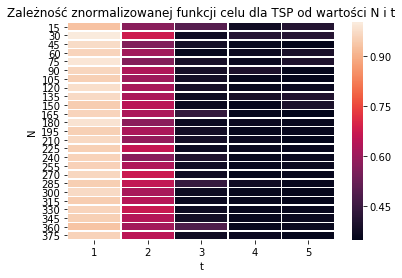

In [70]:
tick_label_x = [f"{i + 1}" for i in range(t_size)]
tick_label_y = [f"{i * 15 + 15}" for i in range(N_size)]

print(evals)
ax = sns.heatmap(evals, linewidth=0.5, xticklabels=tick_label_x, yticklabels=tick_label_y)
plt.xlabel("t")
plt.ylabel("N")
plt.title("Zależność znormalizowanej funkcji celu dla TSP od wartości N i t")

plt.savefig("heat_map_2.png")